# Introduction

This is a notebook for the derivation of the transient water & sediment discharge equation in response to draining an initial water volume V0 in a channel. To be used for simulating overland flow in the groundwater flow and erosion model

## Derivation of the discharge equation

Discharge is calculated using the Gauckler-Manning equation:

$$v = K_n R^{2/3} S^{1/2}$$

where $v$ is the mean flow velocity in a stream channel (m s^-1), Kn is an empirical coefficeint (units....), R is hydraulic radius (m) and S is the slope of the water surface, which is taken as equal to the slope of the channel bed (m m^-1) (ref).

with $R \approx h$ and $C_1 = K_n S^{1/2}$ the equation can be simplified to:

$$v = C_1 h^{2/3}$$

where $h$ is the water height in the channel (m).

The total discharge Qw (m3 s^-1) is equal to the product of the flow velocity (v) and the cross-sectional area $A$ (m2):

$$Q_w = A C_1 h^{2/3}$$

for a triangular shape of the channel, with a linear transverse slope $S_t$ (m/m), the area can be defined as:

$$A = \dfrac{1}{S_t} h^2$$

and the discharge equation can be rewritten as:

$$Q_w = C_2 h^{8/3}$$

where $C_2 = \dfrac{C_1}{S_t}$


# Calculating stream discharge over time

The continuity equation for discharge of a stream channel is given by:

$$\dfrac{\partial V_w}{\partial t} = -Q_w$$

where $V_w$ is the water volume in the channel (m^3^).

Inserting the equation for discharge that was derived above yields:

$$\dfrac{\partial V_w}{\partial t} = -\dfrac{C_1}{S_t}$$

We first define the volume to be discharged as the product of a cross-section area that changes over time and a fixed stream length $L$ (m):

$$V_w = A L$$

again assuming that the shape of the channel is a triangle:

$$A = \dfrac{1}{S_t} h^2$$

inserting this into the continuity equation yields:

$$\dfrac{L}{S_t} \dfrac{\partial h^2}{\partial t} = -C_2 h^{8/3}$$

replacing $h^2$ by $u$ and reorganizing the equation gives:

$$\dfrac{1}{S_t} \dfrac{\partial u}{\partial t} = -C_2 u^{4/3}$$

more rearranging gives:

$$u^{-4/3} \partial u = -C_3  \partial t$$

where $C_3 = C_2 * S_t / L$

integration gives:

$$-3 u^{-1/3} = -C_3 t + C_4$$

where $C_4$ is the new integration constant.

For $u=u_0$ at $t=0$, and therefore:

$C_4 = -3 u_0^{-1/3}$

The equation for the change in u over time becomes:

$$u = \dfrac{1}{u_0^{-1/3} + C_5 t}^3$$

where $C_5 = C_3 / 3$

replacing u by $h^2$ and $u_0$ by $h_0^2$:

$$h = \left( h_0^{-2/3} + C_5 t \right)^{(-3/2)}$$

The initial heigh of the water level in the channel (h0) is a function of the additional water to be discharged (V_0), the lenght of the channel (L), the channel shape and the baseflow (hb). For a triangular channel with transverse slope S_t the total volume in the channel is:

$$V_t = \dfrac{h_0^2 L}{S_t}$$


The volume in the channel contains a steady baseflow component Vb:

$$V_b = \dfrac{h_b^2 L}{S_t}$$

However, we ignore this for now, assuming that the volume of water to be discharge is much larger than the volume in the channel ($V_0 >> V_b$). Therefore:

$$V_0 = \dfrac{h_0^2 L}{S_t}$$

which can be rewritten to yield h:

$$h_0 = \sqrt(V_0 S_t / L)$$

The constant $C_5$ consists of the following parameters:

$$C_5 = \dfrac{K_n S^{1/2}}{3 L}$$ 

adding this back into the equation yields an expression for the decrease of water depth in a channel over time in response to drainage of an initial volume V0:

$$h = \left( \dfrac{V_0 S_t}{L}^{-1/3} + \dfrac{K_n S^{1/2}}{3 L} t \right)^{(-3/2)}$$


## Implementing the analytical equation in Python:

In [13]:
%matplotlib inline

import string
import numpy as np
import matplotlib.pyplot as pl

pl.rcParams['mathtext.default'] = 'regular'

# set up parameters:

# setup an array for time (sec)
n_timesteps = 20000
dt = 1.0
t = np.arange(n_timesteps) * dt

# manning constant
Km = 25.0

# channel slope (m/m)
S = 0.02

# transverse slope of the channel bed
St = 0.05

# upstream length of channel (m)
L = 10000.0

# instantaneous prepitation excess (m)
P = 0.0365

# length of contributing area to saturation overland flow (m)
Ls = 100.0

# calculate initial volume in channel
V0 = L * Ls * P

# and initial height and width of the channel
h0 = (V0 * St / L)**0.5
w0 = h0 / St

In [14]:
# calculate equation constants for analytical equation
C5 = Km * S**0.5 / (3 * L)
u0 = h0**2

In [15]:
# analytical solution for decay of h over time:
u = (1.0 / (u0**(-1/3.) + C5 * t)) ** 3
h = u**(0.5)

# faster way: directly calculate h:
h2 = (1.0 / (h0**(-2/3.) + C5 * t)) ** 1.5

## Checking analytical discharge solution:

We check the analytical solution against numerical solution of discharge equation, ie change in h over time. The numerical solution takes the initial water volume, calculates the water level and channel width (eqs ...) and calculates discharge at each timestep using the Gauckler-Manning equation.

In [16]:
# calculate some constants for the numerical solution:
V = V0

Vs = np.zeros(n_timesteps)
Vs[0] = V
hs = np.zeros_like(Vs)
ws = np.zeros_like(Vs)
Qws = np.zeros_like(Vs)

V0_2d = V0 / L
hs[0] = np.sqrt(V0_2d * St)

for timestep in range(1, n_timesteps):

    # calculate h in a triangular channel, assume that the upstream contributing area 
    # stays the same?
    V_2d = Vs[timestep-1] / L
    
    # calculate the water height, assuming a triangular channel shape
    hs[timestep] = np.sqrt(V_2d * St)

    # calculate the width of the channel (w)
    w = hs[timestep] / St

    ws[timestep] = w
    
    # calculate the cross-sectional area
    #A = 0.5 * hs[timestep] * w
    A = hs[timestep] * w

    #
    R = hs[timestep]

    # calculate Q using the Gauckler-Manning eq:
    Q = Km * A * S**0.5 * hs[timestep]**(2/3.)
    #C2 = Km * S**0.5 / St
    #Q = C2 * hs[timestep]**(8/3.0)
    Qws[timestep] = Q
    
    # todo: check why the two Qs are not the same??
    
    # calculate change in V over one timestep, by removing Q
    Vs[timestep] = Vs[timestep - 1] - Q * dt


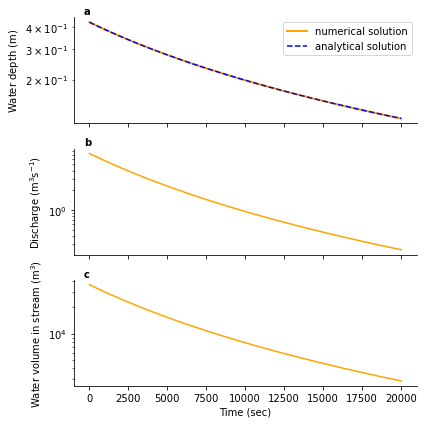

In [17]:
# make a figure of the results:
fig, axs = pl.subplots(3, 1, figsize=(6, 6), sharex=True)

axs[0].plot(t, hs, color='orange', ls = '-', lw=2.0, label='numerical solution')
axs[0].plot(t, h2, color='blue', ls='--', lw=1.5, label='analytical solution')

axs[1].plot(t[1:], Qws[1:], color='orange')

axs[2].plot(t, Vs, color='orange')

#axs[0].set_xlabel('Time (sec)')
axs[0].set_ylabel('Water depth ($m$)')

#axs[1].set_xlabel('Time (sec)')
axs[1].set_ylabel(r'Discharge ($m^3 s^{-1}$)')

axs[2].set_xlabel('Time (sec)')
axs[2].set_ylabel(r'Water volume in stream ($m^3$)')

axs[0].legend(loc='upper right')

for ax in axs:
    #ax.set_xlim(0, t.max())
    ax.set_yscale('log')
    #ax.axhline(y=0, color='black', lw=0.5)
    
for i, panel in enumerate(axs):
    panel.spines['top'].set_visible(False)
    panel.spines['right'].set_visible(False)
    panel.text(0.03, 1.01, string.ascii_lowercase[i], 
            weight='bold', transform=panel.transAxes, ha='left', va='bottom')

fig.tight_layout()

fig.savefig('fig/validation_transient_discharge_eq.pdf')

**Figure caption:** *Comparison of numerical and analytical solution of water depth (h) in a channel following the discharge over time of an initial water volume in this channel (V0). The analytical and numerical solutions match perfectly (pfew)*

## Adding erosion

Next step: calculate erosion flux (Qs) over time:

Following Tucker & Bras (1998) the sediment flux in channels (Q_s, units....) is related to discharge by:

$$Q_s = k_f S^n Q_w^m$$

where subscripts s and w denote the flux of sediment and water, respectively. S is channel bed slope (m m^-1) and k_f (a m^-3), m and n are empirical coefficients.

Following the equations for channel discharge (eq ...) *Q_w* is related to teh water level in the channel *h* by:

$$Q_w = C_2 h^{8/3}$$

inserting the equation for discharge over time (eq ...) into this equation yields:

$$Q_w = C_2 \left( h_0^{-2/3} + C_5 t \right)^{(-4)}$$

Adding the new expression for channel discharge to the sediment discharge equation yields:

$$Q_s = k_f S^n C_2^m \left( h_0^{-2/3} + C_5 t \right)^{(-4m)}$$

adding back the constants C_2 and C_5, and the initial volume V_0

$$C_2 = K_n S^{1/2} / S_t$$

$$C_5 = \dfrac{K_n S^{1/2}}{3 L}$$ 

$$V_0 = \dfrac{h_0^2 L}{S_t}$$

yields the final sediment flux equation:

$$Q_s = k_f S^n (K_n S^{1/2} /S_t)^m \left( (\dfrac{V_0 S_t}{L})^{-1/3} + \dfrac{K_n S^{1/2}}{3 L} t \right)^{-4m}$$



kf = 3.16e-01


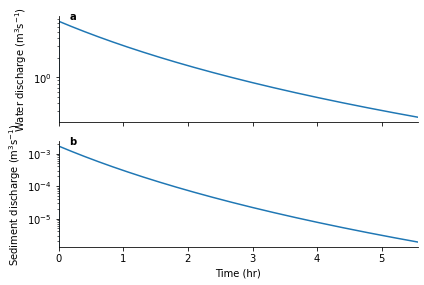

In [18]:
S = 0.01

# Tucker & Brass (1988) kf = 10^-8 yr m^-3
year = 365.24 * 24 * 3600.
kf = 1e-8 * year

print('kf = %0.2e' % kf)

# m = n = 2 (Tucker and Bras 1998, WRR)
m = 2
n = 2

Qs = kf * S**n * Qws**m

fig, axs = pl.subplots(2, 1, figsize=(6, 4), sharex=True)

axs[0].plot(t / 3600., Qws)

axs[1].plot(t / 3600., Qs)

axs[-1].set_xlabel('Time (hr)')
axs[0].set_ylabel(r'Water discharge ($m^3 s^{-1}$)')
axs[1].set_ylabel('Sediment discharge ($m^3 s^{-1}$)')

for ax in axs:
    ax.set_xlim(0, t.max() / 3600.)
    #ax.axhline(y=0, color='black', lw=0.5)
    ax.set_yscale('log')

for i, panel in enumerate(axs):
    panel.spines['top'].set_visible(False)
    panel.spines['right'].set_visible(False)
    panel.text(0.03, 0.95, string.ascii_lowercase[i], 
            weight='bold', transform=panel.transAxes, ha='left', va='bottom')

fig.tight_layout()

fig.savefig('fig/example_water_and_sed_discharge_over_time.pdf')

**Fig. caption** *Calculated water discharge and sediment flux for the test case*

## Calculate integrated sediment flux

Integration of the sediment flux over time. We first simplify the sediment flux a equation by introducing new constants:

$$a =  k_f S^n (K_n S^{1/2} / S_t)^m$$
$$b = \dfrac{V_0 S_t}{L}^{-1/3}$$
$$c = \dfrac{K_n S^{1/2}}{3 L}$$

Using these transforms the sediment discharge eq to:

$$Q_s = a (b + c t)^{-4m}$$

integration from t=0 to t=t1 yields

$$V_s = \left[\dfrac{a (b + c t)^{(-4m+1)}}{-4m c + c} \right]_0^{t_1} $$

or 

$$V_s = \dfrac{a (b + c t_1)^{(-4m+1)}}{-4m c + c} - \dfrac{a (b + c)^{(-4m+1)}}{-4m c + c} $$

where $V_s$ is the eroded sediment volume

which for $t1 = \inf$ can be reduced to:

$$V_s = \dfrac{a (b + c)^{(-4m+1)}}{4m c + c} $$

## Validate against numerical integration



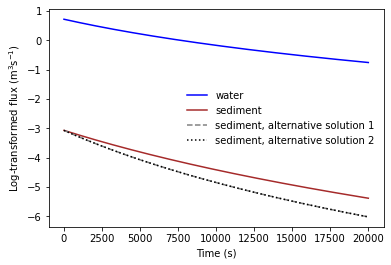

In [19]:
def calculate_sediment_flux(t, a, b, c, m):
    
    return a * (b + c * t) ** (-4*m)

t0 = 0

t1 = 1e4

S = 0.01

# Tucker & Brass (1988) kf = 10^-8 yr m^-3
year = 365.24 * 24 * 3600.
kf = 1e-8 * year

# m = n = 2 (Tucker and Bras 1998, WRR)
m = 2
n = 2

# calculate constants in equation:
a = kf * S**n * (Km *S**0.5 / St)**m
b = ((V0 * St) / L) ** (-1./3.)
c = (Km * S**0.5) / (3 * L)

# Calculate sediment flux over time directly
#ts = np.linspace(0, 1e5, 1e4)
Qs = calculate_sediment_flux(t, a, b, c, m)

# Calculate indirectly using Qw
C1 = Km * S**0.5
C2 = C1 / St
Qw = C2 * h2 **(8.0/3.0)
Qw2 = C2 * (h0**(-2./3.) + C5 * t)**(-4)

# alternative ways to calculate Qs, for doule checking if solution is correct:
Qs1 = kf * S**n * Qw**m
Qs2 = kf * S**n * C2**m * (h0**(-2./3.) + C5*t)**(-4*m)

fig, ax = pl.subplots(1, 1)
ax.plot(t, np.log10(Qw), color='blue', label='water')
ax.plot(t, np.log10(Qs), color='brown', label='sediment')
ax.plot(t, np.log10(Qs1), color='gray', ls='--', label='sediment, alternative solution 1')
ax.plot(t, np.log10(Qs2), color='black', ls=':', label='sediment, alternative solution 2')

ax.legend(loc='center right', frameon=False)
ax.set_ylabel(r'Log-transformed flux ($m^3 s^{-1}$)')

ax.set_xlabel('Time (s)')

fig.savefig('')

**Figure caption** *Calculated change in water and sediment flux (Qw and Qs)(m3 s-1) over time using the numerical solution*

## Check equation for integrated total sediment flux:

Equation for total sediment flux (for see derivation see separate box above):

$$V_s = \dfrac{a (b + c t1)^{(-4m+1)}}{-4m c + c} - \dfrac{a (b + c)^{(-4m+1)}}{-4m c + c} $$

In [20]:
import scipy.integrate

def water_flux(t, h0, C2, C5):
    Qw = C2 * (h0**(-2./3.) + C5 * t)**(-4)
    
    return Qw


def int_term(tx, a, b, c, m):
    
    Vint = a * (b + c * tx) ** (-4*m+1) / (-4*m*c + c)
    
    return Vint

t1 = 0
t2 = np.inf
Vsn = scipy.integrate.quad(calculate_sediment_flux, t1, t2, args=(a, b, c, m))

Vsa = int_term(np.inf, a, b, c, m) - int_term(t1, a, b, c, m)

Vwn = scipy.integrate.quad(water_flux, t1, t2, args=(h0, C2, C5))

print('Numerically integrated water flux = %0.2e m^3, which should be equal to V0 = %0.2e m^3' % (Vwn[0], V0))
print('Integrated sediment flux from t=%0.2f to t=%0.2f' % (t1, t2))
print('numerical integration: %0.2e m^3' % Vsn[0])
print('analytical integration: %0.2e m^3' % Vsa)


Numerically integrated water flux = 2.58e+04 m^3, which should be equal to V0 = 3.65e+04 m^3
Integrated sediment flux from t=0.00 to t=inf
numerical integration: 2.56e+00 m^3
analytical integration: 2.56e+00 m^3


## Set up of function for sediment flux as response to rainfall event

In [21]:
def calculate_sediment_flux_overland_flow(V0, L, S, St, kf, Km, n, m):
    """
    
    
    V0 : initial volume of water to be discharged (m3)
    L : Length of channel
    S : Slope of channel bed
    St : Teansverse slope of channel bed, assuming a triangular channel shape
    kf : empirical coefficient in sediment discharge equation (units...)
    Km : empirical coefficient in the Gauckler-Manning equation (units....)
    n : empirical coefficient in sediment discharge equation (units...)
    m : empirical coefficient in sediment discharge equation (units...)
    """
    
    t0 = np.inf
    t1 = 0.0
    
    # calculate constants in equation:
    a = kf * S**n * (Km *S**0.5 / St)**m
    b = ((V0 * St) / L) ** (-1./3.)
    c = (Km * S**0.5) / (3 * L)
    
    Vsa = a * (b + c * t0) ** (-4*m+1) / (-4*m*c + c) - a * (b + c * t1) ** (-4*m+1) / (-4*m*c + c)
    
    return Vsa

## Sensitivity analysis of sediment discharge using new function

In [22]:
# Fixed parameters

# Tucker & Brass (1988) kf = 10^-8 yr m^-3
year = 365.24 * 24 * 3600.
kf = 1e-8 * year

# manning constant
Km = 1.0 / 0.035

# channel slope (m/m)
S = 0.01

# transverse slope of the channel bed
St = 0.05

# upstream length of channel (m)
L = 10000.0

# instantaneous prepitation excess (m)
P = 0.05 

# length of contributing area to saturation overland flow (m)
Ls = 100.0

V0 = P * Ls * L

In [23]:
# Variable parameters

Ps = np.arange(10, 210, 10) * 1e-3
V0s = Ps * Ls * L

Ss = np.arange(1e-3, 1e-1, 1e-3)

L_s = np.arange(1000, 5e4, 1e3)
V0s2 = P * Ls * L_s

Sts = np.arange(1e-2, 1e-1, 1e-2)

## Calculate sediment flux for different test cases:

In [24]:
sed_fluxes_base = calculate_sediment_flux_overland_flow(V0, L, S, St, kf, Km, n, m)
sed_fluxes_s1 = np.array([calculate_sediment_flux_overland_flow(V0i, L, S, St, kf, Km, n, m) 
                          for V0i in V0s])
sed_fluxes_s2 = np.array([calculate_sediment_flux_overland_flow(V0, L, Si, St, kf, Km, n, m) 
                          for Si in Ss])
sed_fluxes_s3 = np.array([calculate_sediment_flux_overland_flow(V0i, Li, S, St, kf, Km, n, m) 
                          for Li, V0i in zip(L_s, V0s2)])
sed_fluxes_s4 = np.array([calculate_sediment_flux_overland_flow(V0, L, S, Sti, kf, Km, n, m) 
                          for Sti in Sts])


## Make figures of the sensitivity of sediment flux to different parameters

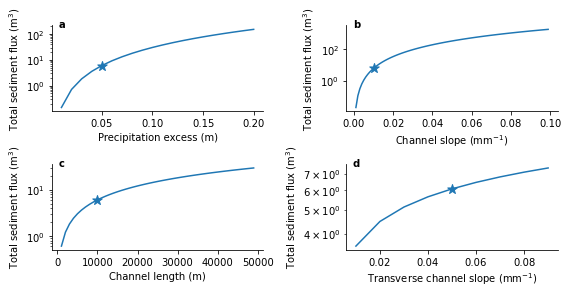

In [25]:
fig, axs_init = pl.subplots(2, 2, figsize=(8, 4))

axs = axs_init.ravel()

axs[0].plot(Ps, sed_fluxes_s1)
axs[0].scatter([P], [sed_fluxes_base], marker='*', s=100)

axs[1].plot(Ss, sed_fluxes_s2)
axs[1].scatter([S], [sed_fluxes_base], marker='*', s=100)

axs[2].plot(L_s, sed_fluxes_s3)
axs[2].scatter([L], [sed_fluxes_base], marker='*', s=100)

axs[3].plot(Sts, sed_fluxes_s4)
axs[3].scatter([St], [sed_fluxes_base], marker='*', s=100)

axs[0].set_xlabel('Precipitation excess (m)')
axs[1].set_xlabel(r'Channel slope ($m m^{-1}$)')
axs[2].set_xlabel('Channel length (m)')
axs[3].set_xlabel(r'Transverse channel slope ($m m^{-1}$)')

for ax in axs:
    ax.set_ylabel(r'Total sediment flux ($m^3$)')
    ax.set_yscale('log')

for i, panel in enumerate(axs):
    panel.spines['top'].set_visible(False)
    panel.spines['right'].set_visible(False)
    panel.text(0.03, 0.95, string.ascii_lowercase[i], 
            weight='bold', transform=panel.transAxes, ha='left', va='bottom')
    
fig.tight_layout()

fig.savefig('fig/transient_sediment_discharge_sensitivity.pdf')

**Figure caption** *Calculated sensitivity of sediment discharge volume in a channel in response to the discharge of an instantaneous precipitation excess. The star denotes the base case*

# References

Tucker, G.E., and Bras, R.L., 1998, Hillslope processes, drainage density and landscape morphology: Water Resources Research, v. 34, p. 2751–2764.